[link text](https://)#AutoEncoders

##Downloading the dataset

###ML-100K

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2020-12-23 16:22:24--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  21.7MB/s    in 0.2s    

2020-12-23 16:22:24 (21.7 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

###ML-1M

In [3]:
!wget "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip ml-1m.zip
!ls

--2020-12-23 16:22:24--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  23.1MB/s    in 0.2s    

2020-12-23 16:22:25 (23.1 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
ml-100k  ml-100k.zip  ml-1m  ml-1m.zip	sample_data


##Importing the libraries

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

## Importing the dataset


In [5]:
# We won't be using this dataset.
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
                                                                        #"::": in the file, the movie name are seperate bt their ratings and other features
                                                                        #None: because the file doesnt have a header
                                                                        #engine: to ensure the data is inout correctly 
                                                                        #'latin-1': because of some special character in the movie title   
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

## Preparing the training set and the test set


In [6]:
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')         
                                                                        #'\t': seperator is a tab 
                                                                        # We have 80k ratings 
training_set = np.array(training_set, dtype = 'int')              
                                                                        #Turning this training set into an array, specify the data type as well(int) 
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [7]:
training_set
            #User, movies, rating, timestamp 

array([[        1,         2,         3, 876893171],
       [        1,         3,         4, 878542960],
       [        1,         4,         3, 876893119],
       ...,
       [      943,      1188,         3, 888640250],
       [      943,      1228,         3, 888640275],
       [      943,      1330,         3, 888692465]])

## Getting the number of users and movies


In [8]:
nb_users = int(max(max(training_set[:, 0], ), max(test_set[:, 0])))
                                                                        #We put in this way instead of the actual number in order to accommodate other files as well
                                                                        #we get the maximum values of user columns of both files and then see which one has the higher number  
nb_movies = int(max(max(training_set[:, 1], ), max(test_set[:, 1])))

In [9]:
print('nb_user:', nb_users)
print('nb_movies:', nb_movies)

nb_user: 943
nb_movies: 1682


## Converting the data into an array with users in lines and movies in columns


In [10]:
#It goes like, the 1st list is for the 1st user, 2nd list is for 2nd user,.... In each list, is the rating of 1682 films so if the movie is not there, then we just put "0" rating
def convert(data):
  new_data = []        
  for id_users in range(1, nb_users + 1):                                #Running through all the users id from 1 to max (pay attention to the upper bound)
    id_movies = data[:, 1] [data[:, 0] == id_users]
                                                                         #Take all the id from with the condition user_id = to the user_id  we are working on 
                                                                         #data[:, 1]: the movies id 
                                                                         #[data[:, 0] == id_users] : condition 
    id_ratings = data[:, 2] [data[:, 0] == id_users]
                                                                         #Take all the ratings from with the condition user_id  = to the user_id  we are working on 
                                                                         #data[:, 2]: the movies id 
    ratings = np.zeros(nb_movies)                                        
                                                                         #Initialize the list of zeros to make sure
    ratings[id_movies - 1] = id_ratings                                  
                                                                         #Replace 0 with the real rating by only targeting "ratings" list at [id_movies - 1] index positions                                                                
    new_data.append(list(ratings))
                                                                         #Add the whole "ratings" you just created into the new_data 
  return new_data
training_set = convert(training_set)
test_set = convert(test_set)

## Converting the data into Torch tensors


In [11]:
training_set = torch.FloatTensor(training_set)                          
                                                                        #FloatTensor: create an object of this class and the single type is "float" 
                                                                        #We have to turn it into the list of lists because the FloatTensor class expects a list of list      
test_set = torch.FloatTensor(test_set)

In [12]:
training_set

tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

## Creating the architecture of the Neural Network


In [13]:
class SAE(nn.Module):                              #SAE: Stacked auto encoders
                                                   #The class is called Module from the "nn" module that we imported above                      
    #Innitalize the object of the class (start at every class)
    def __init__(self, ):                      
        super(SAE, self).__init__()                #"super" function to get the inheritance from the Module class, to get the "Linear" class that we can see below 
        #Full connectiopn between the input vector feature (the ratings of all the movies for 1 specific user) + first hidden layer (shorter vector than the input vector) 
        self.fc1 = nn.Linear(nb_movies, 20)        #"self.fc1" means the 1st full connection related to our auto-encoders object. 
                                                   # 1/ the # of feature in the input vector (nb_movies), 2/ the # of nodes or neurons or features (you can experiment here and decide which numbers later on but for now- 20) 
        self.fc2 = nn.Linear(20, 10)               # 1/ the # of feature in the input vector (20 from the 1st layer), 2/ the # of nodes or neurons or features (you can experiment here and decide which numbers later on but for now- 10) 
        self.fc3 = nn.Linear(10, 20)               # Like above, but at this point we are decoding so go back to 20 
        self.fc4 = nn.Linear(20, nb_movies)        # Like above, but at the end we are decoding so go back to the "nb_movies"
        self.activation = nn.Sigmoid()             # Activation function use "Sigmoid"  
    #Proceeding to the different encodings and decodings when the observation is forwarded into the network, return in the end the vector of predicted ratings that we will compare with the real vector of real ratings 
    def forward(self, x):                          #1/ "self": to specified that the fuction we' ll use will be applied from our object, 2/ "x" is the input vector 
        x = self.activation(self.fc1(x))           #Encoding."self.fc1(x)" from above serves as the input vector, return the first encoder after the first layer. "x" is the input vector 
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))           #Decoding
        x = self.fc4(x)                            #Reconstructed output vector
        return x
sae = SAE()
criterion = nn.MSELoss()                           #"MSELoss" is a class and "criterion" will be an object of this class 
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)
                                                   # "optimizer" applying to the gradiant decent to update the different in order to reduce error at each opoch
                                                   # Decided to go with "RMSprop" class from the optim module
                                                   # "sae.parameters()": gets all the parameters from the SAE class. 
                                                   # "lr": learning rate, experiment & settle with 0.01.
                                                   # "weight_decay":  the decay is used to reduce the learning rate after a few epochs and that is in order to regulate the convergence

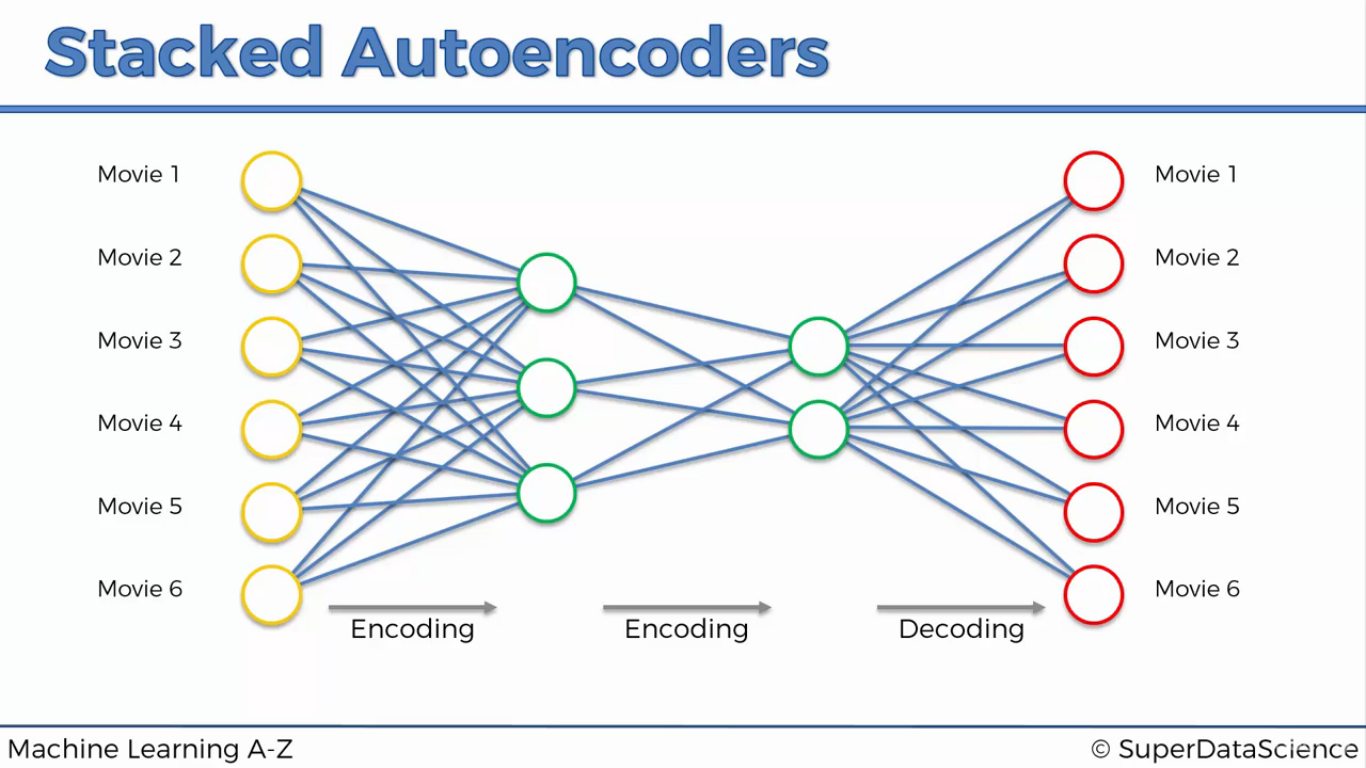

## Training the SAE


In [14]:
nb_epoch = 200
#Looping through all the epoches
for epoch in range(1, nb_epoch + 1):
  train_loss = 0                                                           
  s = 0.                                                                 #Count the users that rate at least a movie     
  #Looping through all the users 
  for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)                 #"id_user" corresponds to the index of the observation corresponding to the user 
                                                                         #Pytroch network and its function dont accept a single vector of one dimension as input so we add "unsqeeze" to create that dimension, "0" to put the new dimension in first position 
    target = input.clone()                                               #Create a "clone" of the input vector and use it as "target" for doing otjher 
    #Using "if" to optimize the memory (saving as much memory as possible) by only looking at users who rated at least 1 movie
    if torch.sum(target.data > 0) > 0:                                   #"target.data" All the ratings of the user at the loop right now. Must >0
                                                                         # Checking if this sum is larger than 0, if that is the case then that the observation contains at least one rating that is not zero 
      output = sae(input)                                                # output: Output of the predicted rating
      target.require_grad = False                                        #To make sure we dont compute the "target"'s gradients. Save computational power  
      output[target == 0] = 0                                            #Save computational power by just working on non-0 predicted vector values. Simce "target == 0" will not be counted, it wont have an impact on the  "output"
      loss = criterion(output, target)                                   #Use the "criterion" function that we created above to compute loss by MSELoss style 
                                                                         #1/ Predicted value- "output". 2/ the standard result-"target"    
      mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)      # "nb_movies/ nb_movies_with_positive_ratings" mean the averge of the errors of the movies that got at least 1 ratings
                                                                                # "torch.sum(target.data > 0) + 1e-10" is the number of rating."+ 1e-10" for mathematical reason 
      loss.backward()                                                    # Tell which direction to update the weight 
      train_loss = train_loss + np.sqrt(loss.data*mean_corrector)        # Update the "train_loss" according to the formula. "loss.data" is the data section of the "loss"
      s = s + 1.                                                         # If the user satisfy the if function then we +1 to keep track 
      optimizer.step()                                                   # "step()" is the function inside the "optimizer" class we created above   
  print('epoch: ' + str(epoch) + ' / loss: '+ str(train_loss/s))         # "train_loss/s" because we want the average of train_loss by the number of movies is rated
                                                                         # If "train_loss/s" = 1 at the end then it is not so bad because that means we make a mistake 1 star out of 5  

epoch: 1 / loss: tensor(1.7723)
epoch: 2 / loss: tensor(1.0967)
epoch: 3 / loss: tensor(1.0535)
epoch: 4 / loss: tensor(1.0383)
epoch: 5 / loss: tensor(1.0307)
epoch: 6 / loss: tensor(1.0267)
epoch: 7 / loss: tensor(1.0239)
epoch: 8 / loss: tensor(1.0219)
epoch: 9 / loss: tensor(1.0206)
epoch: 10 / loss: tensor(1.0196)
epoch: 11 / loss: tensor(1.0189)
epoch: 12 / loss: tensor(1.0185)
epoch: 13 / loss: tensor(1.0180)
epoch: 14 / loss: tensor(1.0174)
epoch: 15 / loss: tensor(1.0171)
epoch: 16 / loss: tensor(1.0170)
epoch: 17 / loss: tensor(1.0164)
epoch: 18 / loss: tensor(1.0162)
epoch: 19 / loss: tensor(1.0163)
epoch: 20 / loss: tensor(1.0164)
epoch: 21 / loss: tensor(1.0159)
epoch: 22 / loss: tensor(1.0160)
epoch: 23 / loss: tensor(1.0160)
epoch: 24 / loss: tensor(1.0156)
epoch: 25 / loss: tensor(1.0156)
epoch: 26 / loss: tensor(1.0158)
epoch: 27 / loss: tensor(1.0151)
epoch: 28 / loss: tensor(1.0151)
epoch: 29 / loss: tensor(1.0137)
epoch: 30 / loss: tensor(1.0112)
epoch: 31 / loss: t

## Testing the SAE


In [15]:
#Copying wgat we have above and modify accordingly 

test_loss = 0                                                   #Turn into "test_loss"
s = 0.                                                    
for id_user in range(nb_users):
  input = Variable(training_set[id_user]).unsqueeze(0)           # Keep the "training_set" here to activate the neurons and predict the mmovies the users havent watch yet 
  target = Variable(test_set[id_user]).unsqueeze(0)              # Test set as the target 
  if torch.sum(target.data > 0) > 0:
    output = sae(input)
    target.require_grad = False
    output[target == 0] = 0                               
    loss = criterion(output, target)
    mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
                                                                 #Delete the "loss.backward()" line
    test_loss = test_loss + np.sqrt(loss.data*mean_corrector)    #Replace "train_loss" with "test_loss"  
    s += 1.
                                                                 #We dont need thje "optimizer" because it is heavily associated with the training set and backward propagantion process
print('test loss: '+str(test_loss/s))

test loss: tensor(0.9589)
